# 📷 Session 3: The AI Field Ecologist
**Objective:** Automate detection and identification of terrestrial animals from camera-trap images.


**Tools:**
1.  **[MegaDetector](https://megadetector.readthedocs.io/):** A model trained on millions of camera trap images to find "Animals" (bounding boxes).
 - MegaDetector is "dumb"—it only knows "Animal" or "Human". It doesn't know species.
2.  **[BioCLIP](https://imageomics.github.io/bioclip/):** A foundation model that knows the taxonomy of 450,000 species. It looks at the box and says "That's a *Procavia capensis*".
 - BioCLIP is smart, but slow. We only run it on the small cropped boxes (efficiency).


This code installs the libraries into the current Pixi environment and defines the helper functions.
If you're already in the `pixi shell` with the `default` env, just run the install cell once.


In [6]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import os, shutil
from io import BytesIO
import urllib.request
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

import torch
import open_clip
from megadetector.detection import run_detector


In [7]:
# Setup Device
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


# Detecting animals using MegaDetector

In [8]:
# Load MegaDetector
print("Loading MegaDetector...")
detector = run_detector.load_detector('MDV5A')

Loading MegaDetector...


Fusing layers... 
Fusing layers... 


Model v5a.0.1 already exists and is valid at /var/folders/vc/qm7741c57dsg9f7wyrtrdrrm0000gq/T/megadetector_models/md_v5a.0.1.pt
PyTorch reports 0 available CUDA devices
PyTorch reports Metal Performance Shaders are available
GPU available: True
Bypassing imports for model type yolov5
Loading PT detector with compatibility mode classic
Loaded image size 1280 from model metadata
Using model stride: 64
Using MPS device
PTDetector using device mps


Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


In [9]:
image_url = "https://storage.googleapis.com/public-datasets-lila/snapshot-safari-2024-expansion/KAR/KAR_S2/C01/C01_R2/KAR_S2_C01_R2_IMAG0210.JPG"

with urllib.request.urlopen(image_url) as response:
    image = Image.open(BytesIO(response.read())).convert('RGB')


In [10]:
# Detect with MegaDetector
results = detector.generate_detections_one_image(image)
detections = [detect for detect in results['detections'] if detect['conf'] > 0.2]
print(f"🔎 Found {len(detections)} animals.")

🔎 Found 1 animals.


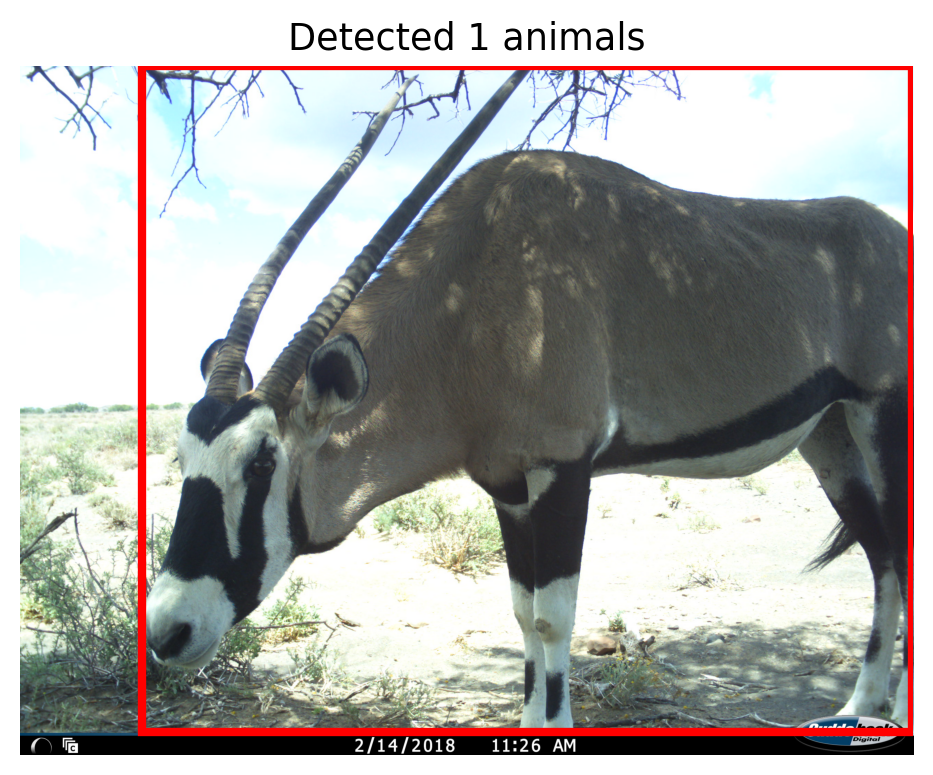

In [13]:
# Draw boxes with matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(image)
ax.axis('off')
ax.set_title(f"Detected {len(detections)} animals")
width, height = image.size
for det in detections:
    x, y, w, h = det['bbox']  # [x_min, y_min, width, height]
    x1, y1 = x * width, y * height
    rect = plt.Rectangle(
        (x1, y1), w * width, h * height,
        linewidth=3, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
plt.tight_layout()

# Terrestrial camera-trap classification with BioCLIP
**Goal:** Use a foundation model to identify species *without* training it.

**Why change?** Underwater fish images are extremely blurry and the domain gap is large.
Camera-trap images are a "solved" domain: clear, terrestrial photos that BioCLIP handles well.

We'll use a *small sample* from the **Snapshot Karoo** dataset (South Africa) and run:
   
  (1) MegaDetector → (2) crop animal → (3) BioCLIP zero-shot classification.


In [53]:
# Load metadata to get true species labels
import json

print("Loading metadata...")
with open('snapshot_safari_top10_subset.json', 'r') as f:
    metadata = json.load(f)

# Extract true species for our sample images
def get_true_species(image_url, metadata):
    """Extract the true species from metadata for a given image URL"""
    # Parse the image path from URL
    # e.g., "KAR/KAR_S2/C01/C01_R2/KAR_S2_C01_R2_IMAG0210.JPG"
    image_key = "/".join(image_url.split("/")[-5:])
    
    # Search through metadata
    for entry in metadata.get('images', []):
        if entry.get('file_name', '').endswith(os.path.basename(image_url)):
            # Get annotations for this image
            image_id = entry.get('id')
            for ann in metadata.get('annotations', []):
                if ann.get('image_id') == image_id:
                    # Get category name
                    category_id = ann.get('category_id')
                    for cat in metadata.get('categories', []):
                        if cat.get('id') == category_id:
                            return cat.get('name', 'Unknown')
    return 'Unknown'

print(f"Loaded metadata with {len(metadata.get('images', []))} images")

Loading metadata...
Loaded metadata with 100 images


In [56]:
# Extract sample URLs from metadata
from urllib.parse import quote
base_url = "https://storage.googleapis.com/public-datasets-lila/snapshot-safari-2024-expansion/"
image_dir = "karoo_sample"

# Build list of image URLs from metadata
sample_urls = []
for img_entry in metadata.get('images', []):
    file_name = img_entry.get('file_name', '')
    if file_name:
        # URL-encode the filename to handle spaces and special characters
        encoded_path = quote(file_name)
        sample_urls.append(base_url + encoded_path)

print(f"Found {len(sample_urls)} images in metadata")

Found 100 images in metadata


In [ ]:
# Download the sample images
if os.path.exists(image_dir):
    shutil.rmtree(image_dir)
os.makedirs(image_dir, exist_ok=True)

print(f"⬇Downloading {len(sample_urls)} images into {image_dir}...")

def download_image(url):
    filename = os.path.join(image_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, filename)
    return filename

with ThreadPoolExecutor() as executor:
    sample_paths = list(executor.map(download_image, sample_urls))

print(sample_paths)


⬇Downloading 100 images into karoo_sample...
['karoo_sample/APN_S3_DW_R11_IMAG0680.JPG', 'karoo_sample/APN_S3_DW_R8_IMAG0578.JPG', 'karoo_sample/APN_S3_JJ6_R12_IMAG0166.JPG', 'karoo_sample/APN_S3_K034_R10_IMAG0224.JPG', 'karoo_sample/APN_S3_U23a_R8_IMAG0072.JPG', 'karoo_sample/APN_S3_U63c_R11_IMAG0436.JPG', 'karoo_sample/APN_S4_DW_R13_IMAG0161.JPG', 'karoo_sample/BLO_S1_C03_R1_IMAG1028.JPG', 'karoo_sample/CDB_S1_E05_R1_IMAG0157.JPG', 'karoo_sample/DEB_S1_D7_R53_IMAG0437.JPG', 'karoo_sample/DEB_S1_D7_R58_IMAG0537.JPG', 'karoo_sample/DEB_S1_F9_R52_IMAG0393.JPG', 'karoo_sample/DEB_S1_H8_R77_IMAG0115.JPG', 'karoo_sample/EFA_S1_EFA06_R3_IMAG0360.JPG', 'karoo_sample/EFA_S1_EFA07_R1_IMAG1121.JPG', 'karoo_sample/EFA_S1_EFA07_R1_IMAG1224.JPG', 'karoo_sample/EFA_S1_EFA07_R21_IMAG1705.JPG', 'karoo_sample/EFA_S1_EFA07_R23_IMAG0563.JPG', 'karoo_sample/EFA_S1_EFA08_R28_IMAG0856.JPG', 'karoo_sample/ENO_S3_D01_R1_IMAG0258.JPG', 'karoo_sample/ENO_S5_E06_R2_IMAG0183.JPG', 'karoo_sample/KAR_S1_E02_R1_IMA

In [58]:
# Load BioCLIP - first time takes several minutes
print("Loading BioCLIP...")
bioclip_model, _, preprocess = open_clip.create_model_and_transforms(
    'hf-hub:imageomics/bioclip', precision='fp16' # use "half precision" (fp16) for speed
)
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')
bioclip_model.to(device);


Parsing model identifier. Schema: hf-hub, Identifier: imageomics/bioclip
Parsing model identifier. Schema: hf-hub, Identifier: imageomics/bioclip
Attempting to load config from HF Hub: imageomics/bioclip
Attempting to load config from HF Hub: imageomics/bioclip
HTTP Request: HEAD https://huggingface.co/imageomics/bioclip/resolve/main/open_clip_config.json "HTTP/1.1 307 Temporary Redirect"
HTTP Request: HEAD https://huggingface.co/imageomics/bioclip/resolve/main/open_clip_config.json "HTTP/1.1 307 Temporary Redirect"


Loading BioCLIP...


HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/imageomics/bioclip/90bfce36c3fc275e9c66afd015e6b4f37e1084f6/open_clip_config.json "HTTP/1.1 200 OK"
HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/imageomics/bioclip/90bfce36c3fc275e9c66afd015e6b4f37e1084f6/open_clip_config.json "HTTP/1.1 200 OK"
Loaded model config from HF Hub: imageomics/bioclip
Loaded model config from HF Hub: imageomics/bioclip
HTTP Request: HEAD https://huggingface.co/imageomics/bioclip/resolve/main/open_clip_model.safetensors "HTTP/1.1 404 Not Found"
HTTP Request: HEAD https://huggingface.co/imageomics/bioclip/resolve/main/open_clip_model.safetensors "HTTP/1.1 404 Not Found"
HTTP Request: HEAD https://huggingface.co/imageomics/bioclip/resolve/main/open_clip_pytorch_model.bin "HTTP/1.1 302 Found"
HTTP Request: HEAD https://huggingface.co/imageomics/bioclip/resolve/main/open_clip_pytorch_model.bin "HTTP/1.1 302 Found"
Found default weights file on HF Hub: /Users/yoavram/.cache/hu

In [59]:
# Zero-shot taxonomy setup - extract from metadata
taxonomy = [cat['name'] for cat in metadata.get('categories', [])]
print(f"Taxonomy ({len(taxonomy)} species): {taxonomy}")

# BioCLIP works best with just the binomial name
with torch.no_grad():
    text_tokens = tokenizer(taxonomy).to(device)
    text_features = bioclip_model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

Taxonomy (10 species): ['empty', 'impala', 'zebraplains', 'wildebeestblue', 'elephant', 'baboon', 'oryx', 'kudu', 'gazellethomsons', 'vulture']


In [69]:
# Detect with MegaDetector + classify with BioCLIP

DETECTOR_MIN_CONF = 0.9

def detect_and_classify(image_path):
    image = Image.open(image_path).convert('RGB')
    results = detector.generate_detections_one_image(image)
    all_animal_detections = [
        d for d in results['detections']
        if str(d.get('category')) == '1'
    ]
    
    # Get max confidence for reporting, even if below threshold
    max_det_conf = max([d.get('conf', 0) for d in all_animal_detections]) if all_animal_detections else 0.0
    
    detections = [
        d for d in all_animal_detections
        if d.get('conf', 0) > DETECTOR_MIN_CONF
    ]
    if not detections:
        return image, None, None, float(max_det_conf)

    # Use the top-confidence animal detection
    det = max(detections, key=lambda d: d['conf'])
    detector_conf = float(det['conf'])
    x, y, w, h = det['bbox']
    width, height = image.size
    x1, y1 = int(x * width), int(y * height)
    x2, y2 = x1 + int(w * width), y1 + int(h * height)
    crop = image.crop((x1, y1, x2, y2))

    # BioCLIP zero-shot
    with torch.no_grad():
        image_input = preprocess(crop).unsqueeze(0).to(device).half() # convert image half precision to match model
        image_features = bioclip_model.encode_image(image_input)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = (image_features @ text_features.T).squeeze(0)
        probs = logits.softmax(dim=-1)
        top_idx = int(probs.argmax().item())
        pred_species = taxonomy[top_idx]
        bioclip_conf = float(probs[top_idx].item())

    bbox = (x1, y1, x2, y2)
    return image, (pred_species, detector_conf, bioclip_conf), bbox, float(max_det_conf)

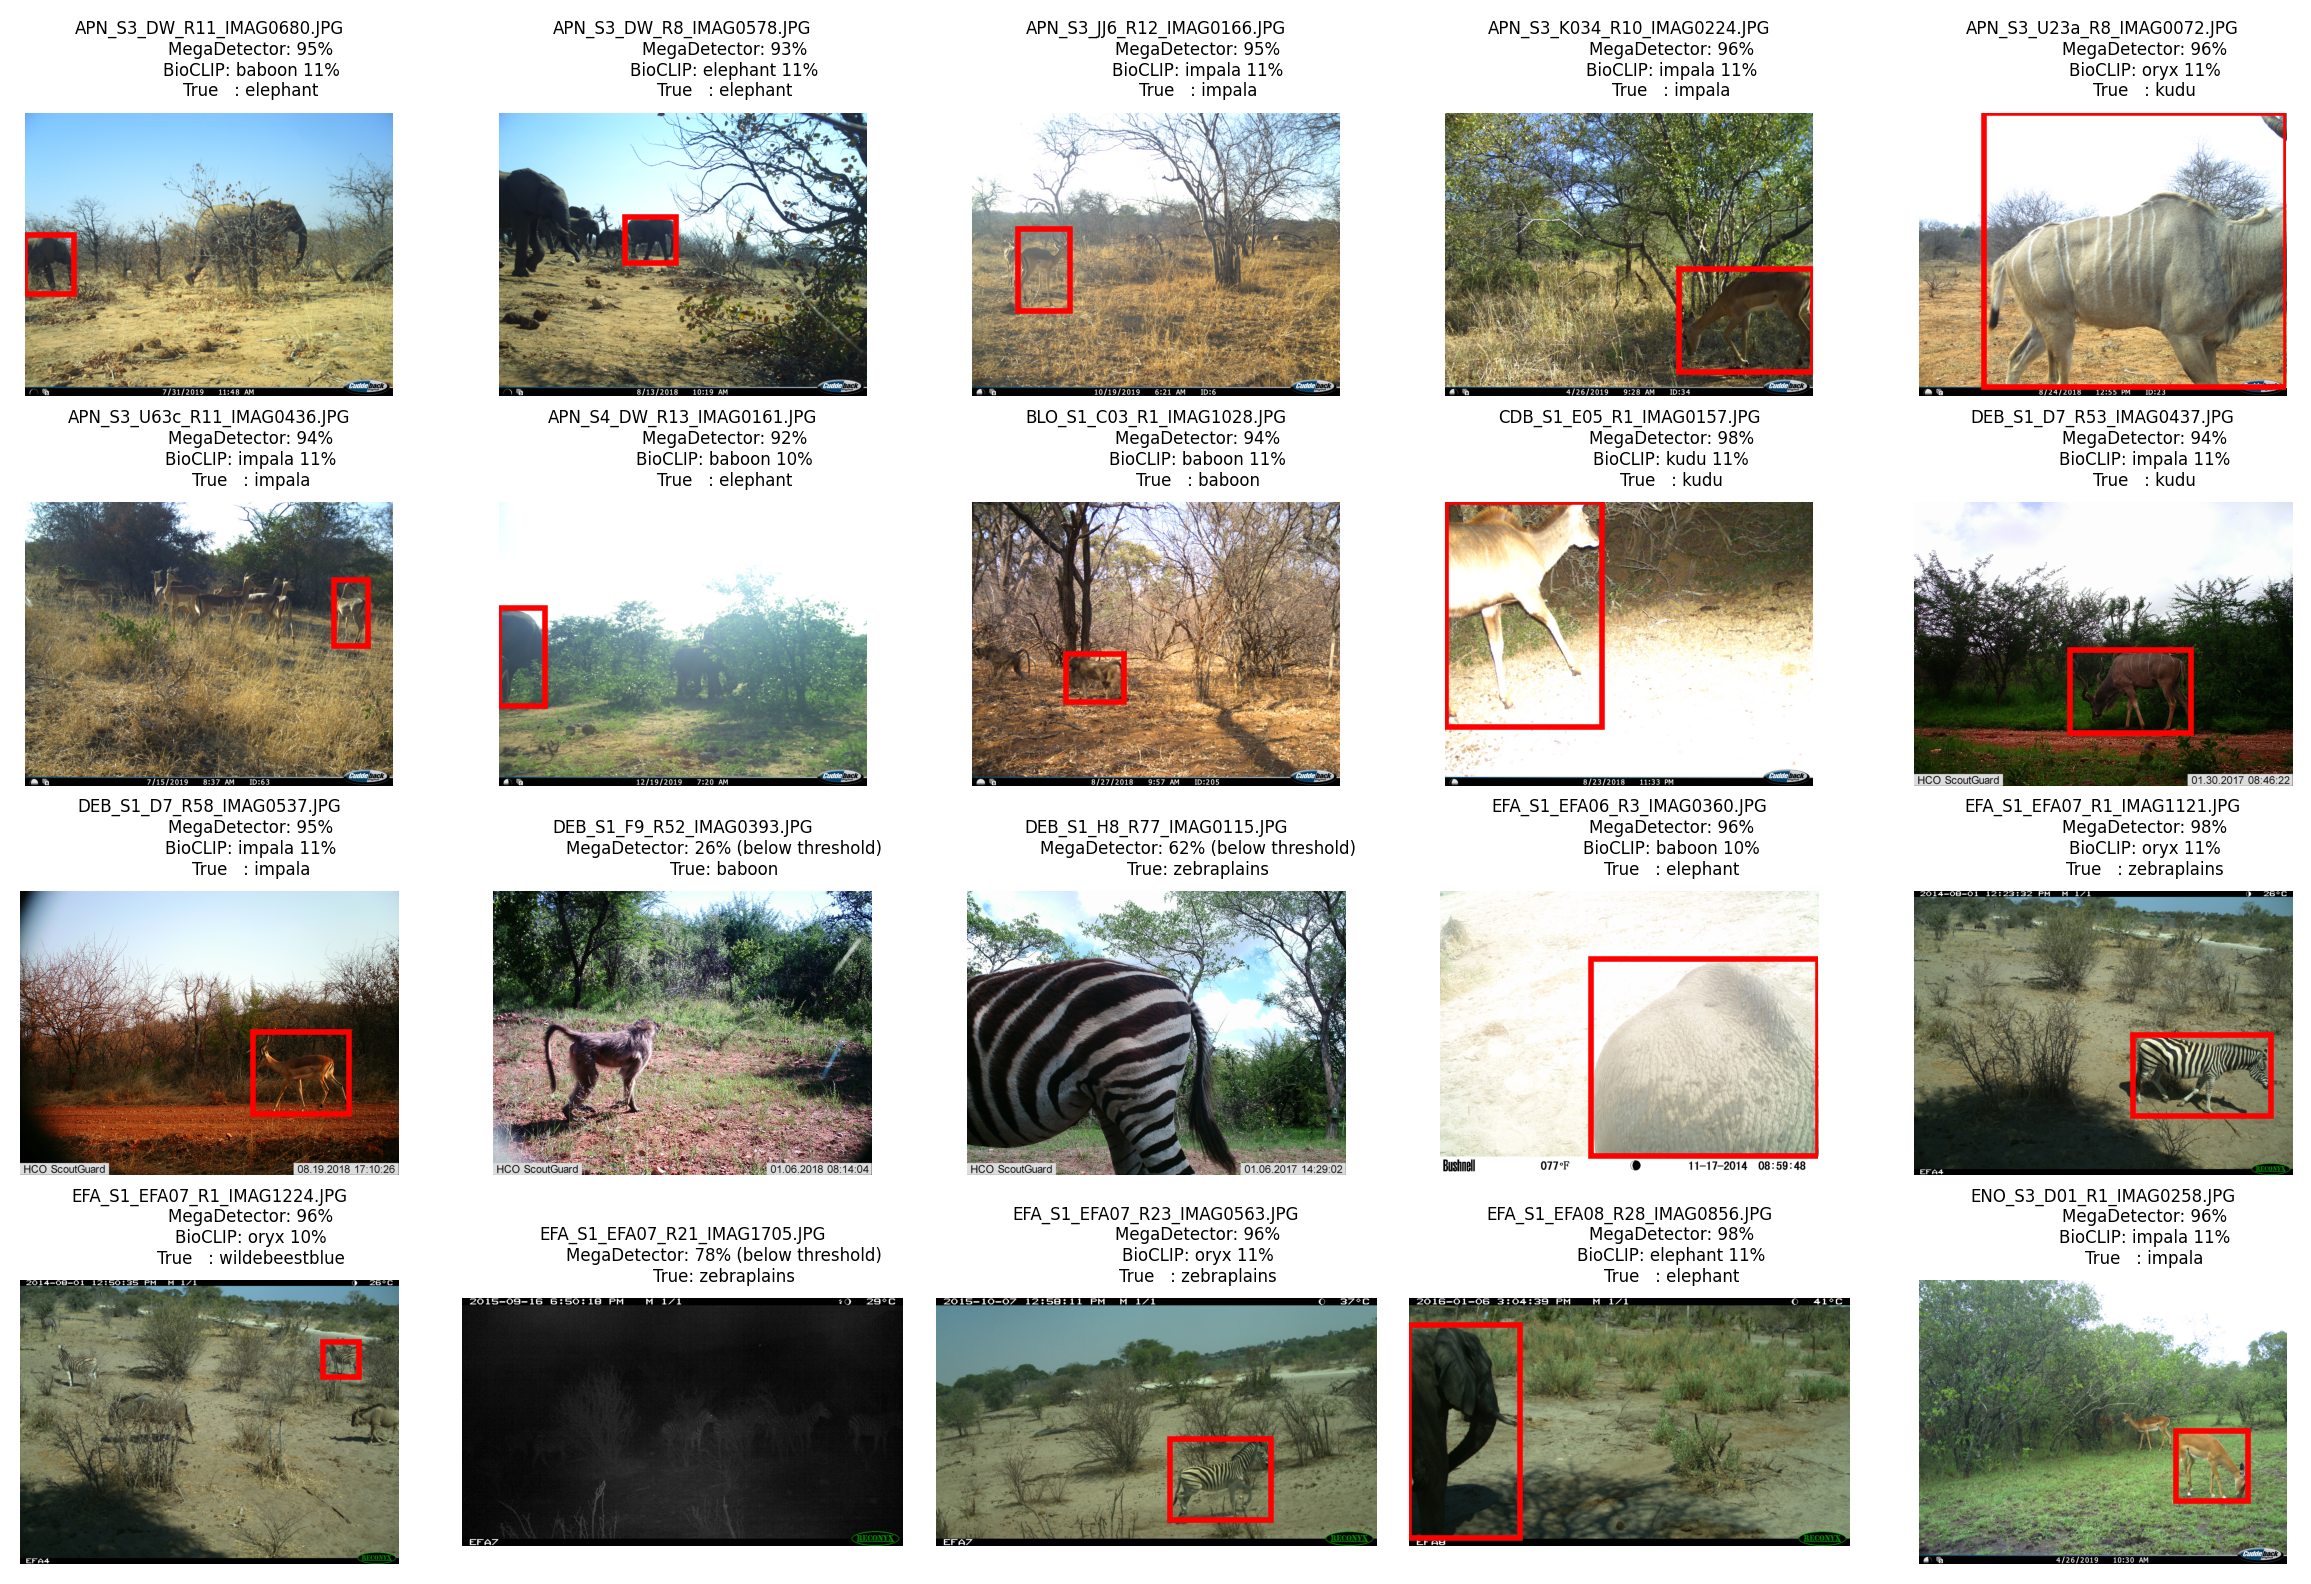

In [68]:
# Run on the sample images (first 20)
plt.figure(figsize=(12, 8))
num_to_plot = min(20, len(sample_paths))
for i, img_path in enumerate(sample_paths[:num_to_plot]):
    img, pred, bbox, max_det_conf = detect_and_classify(img_path)
    ax = plt.subplot(4, 5, i + 1)
    ax.imshow(img)
    file_name = os.path.basename(img_path)
    ax.axis('off')
    if pred is None:
        true_species = get_true_species(sample_urls[i], metadata)
        ax.set_title(f"""{file_name}
                MegaDetector: {max_det_conf:.0%} (below threshold)
                True: {true_species}""", fontdict={'fontsize': 6})
    else:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        pred_species, detector_conf, bioclip_conf = pred
        true_species = get_true_species(sample_urls[i], metadata)
        ax.set_title(f"""{file_name}
                MegaDetector: {detector_conf:.0%}
                BioCLIP: {pred_species} {bioclip_conf:.0%}
                True   : {true_species}""", fontdict={'fontsize': 6})
plt.tight_layout()